In [2]:
#imports
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.nn.functional as F
from torch.autograd import Variable # storing data while learning
from torch.distributions import constraints, multivariate_normal, Normal
from torch.distributions.distribution import Distribution
from torch.utils.data import DataLoader, Dataset


## First loading the recorded data

In [3]:
class CoordinateDataset(Dataset):
    
    def __init__(self, file_name, per_val=1/72):
        random_seed= 42
        file_out = pd.read_csv(file_name, names=['ball_x', 'ball_y', 'positionLeftShoulderRoll', 'positionLeftShoulderPitch'])
        print(f"Number of samples: {len(file_out)}")
        file_out.drop_duplicates(subset=['ball_x','ball_y'], inplace=True)
        deduplicted_count = len(file_out)
        print(f"Number of samples after removing duplicates: {deduplicted_count}")
        x = file_out[['ball_x','ball_y']].values
        y = file_out[['positionLeftShoulderRoll', 'positionLeftShoulderPitch']].values
        
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        indices = list(range(deduplicted_count))
        split = int(np.floor(per_val * deduplicted_count))
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]
        self.x_all = Variable(x_tensor)
        self.y_all = Variable(y_tensor, requires_grad=False)
        self.x_train = Variable(x_tensor[train_indices]).squeeze()
        self.y_train = Variable(y_tensor[train_indices], requires_grad=False).squeeze()
        self.x_val = Variable(x_tensor[val_indices], requires_grad=False).squeeze()
        self.y_val = Variable(y_tensor[val_indices], requires_grad=False).squeeze()
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]
        
dataset = CoordinateDataset('../controllers/tutorial2_tracker/data_points.csv')

Number of samples: 160
Number of samples after removing duplicates: 72


## Then training the MDN

In [4]:
class MDN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_gaussians):
        super(MDN, self).__init__()
        self.n_gaussians = n_gaussians
        self.fc1 = nn.Linear(n_input, n_hidden)
        
        #IMPORTANT notes
        # - Use softmax activation for pi  (they need to add up to 1)
        # - Use exponential linear unit for deviations (they should not be negative or close to zero)
        self.pis = nn.Linear(n_hidden, n_gaussians) # Coefficents
        self.mus = nn.Linear(n_hidden, n_gaussians * n_output) # Means
        self.sigmas = nn.Linear(n_hidden, n_gaussians) # Variances / Deviations
        

    def forward(self, x):
        #Program the forward pass
        x = torch.tanh(self.fc1(x))
        pi = F.softmax(self.pis(x), -1)
        sigma = torch.exp(self.sigmas(x))
        mu = self.mus(x)
        
        return pi, sigma, mu

In [5]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def loss_fn(pi, sigma, mu, y):
    N, K = pi.shape
    _, KT = mu.shape
    NO = int(KT / K)
    losses = Variable(torch.zeros(N, K))
    for i in range(K): 
        window_mu = mu[:, i*NO:(i+1)*NO]
        sigma_expanded = sigma[:, i].unsqueeze(-1).repeat(1, NO)
        likelihood_z_x = -torch.log(gaussian_distribution(y, window_mu, sigma_expanded))
        prior_z = pi[:, i]
        losses += torch.mean(prior_z.unsqueeze(-1).repeat(1, NO) * likelihood_z_x)
    loss = torch.mean(losses)
    return loss

In [162]:
NGAUSSIANS = 4
EPOCHS = 20000
model = MDN(n_input=2, n_hidden=20, n_output=2, n_gaussians=NGAUSSIANS)
optimizer = torch.optim.Adam(model.parameters(), eps=1e-2) # Select optimizer
mdn_train_losses = []
mdn_validation_losses = []

In [163]:
def train_mdn(network, x_train, y_train, x_val, y_val):
    for epoch in range(EPOCHS):            
        pi_variable, sigma_variable, mu_variable = network(x_train)
        train_loss = loss_fn(pi_variable, sigma_variable, mu_variable, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        mdn_train_losses.append(train_loss.item())
        if len(x_val):
            pi_variable, sigma_variable, mu_variable = network(x_val)
            val_loss = loss_fn(pi_variable, sigma_variable, mu_variable, y_val)
            mdn_validation_losses.append(val_loss.item())

        if epoch % 500 == 0:
            if len(x_val):
                print(epoch, train_loss.item(), val_loss.item())
            else:
                print(epoch, train_loss.item())                

In [164]:
train_mdn(model, dataset.x_train, dataset.y_train, dataset.x_val, dataset.y_val)

0 inf nan
500 nan nan
1000 nan nan
1500 nan nan


KeyboardInterrupt: 

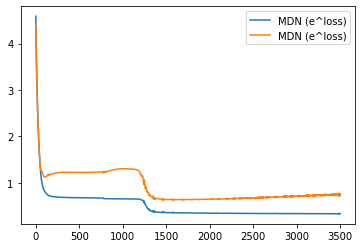

In [143]:
plt.plot(np.exp(mdn_train_losses[:3500]), label="MDN (e^loss)")
plt.plot(np.exp(mdn_validation_losses[:3500]), label="MDN (e^loss)")
plt.legend()
plt.savefig('MDN_loss_3500_samples.png')
plt.show()

In [226]:
NGAUSSIANS = 5
EPOCHS = 20000
model = MDN(n_input=2, n_hidden=20, n_output=2, n_gaussians=NGAUSSIANS)
optimizer = torch.optim.Adam(model.parameters(), eps=1e-5) # Select optimizer

In [227]:
train_mdn(model, dataset.x_train, dataset.y_train, [], [])

0 1.405687689781189
500 -1.2385876178741455
1000 -1.4040666818618774
1500 -1.5414674282073975
2000 -1.5891897678375244
2500 -1.6237088441848755
3000 -1.638383388519287
3500 -1.6551529169082642
4000 -1.6451473236083984
4500 -1.6279864311218262
5000 -1.6115610599517822
5500 -1.710038661956787
6000 -1.654036045074463
6500 -1.7320054769515991
7000 -1.7415828704833984
7500 -1.7147029638290405
8000 -1.7183215618133545
8500 -1.7563360929489136
9000 -1.7665117979049683
9500 -1.787009358406067
10000 -1.6961346864700317
10500 -1.7914389371871948
11000 -1.8033446073532104
11500 -1.7709144353866577
12000 -1.8136570453643799
12500 -1.7529937028884888
13000 -1.827904224395752
13500 -1.7905620336532593
14000 -1.8277989625930786
14500 -1.8144646883010864
15000 -1.8375742435455322
15500 -1.8573106527328491
16000 -1.8449437618255615
16500 -1.8641479015350342
17000 -1.868325114250183
17500 -1.8763080835342407
18000 -1.831475019454956
18500 -1.7264975309371948
19000 -1.8723245859146118
19500 -1.7395778894

In [228]:
torch.save(model.state_dict(), f'mdn_model_nao_{int(EPOCHS/1000)}kepochs_{NGAUSSIANS}gaussians')

# Interpreting the results

In [65]:
import seaborn as sns

In [167]:
NGAUSSIANS = 2

In [175]:
model_two = MDN(n_input=2, n_hidden=20, n_output=2, n_gaussians=2)
model_four = MDN(n_input=2, n_hidden=20, n_output=2, n_gaussians=4)
model_five = MDN(n_input=2, n_hidden=20, n_output=2, n_gaussians=5)

In [176]:
for model in [model_two, model_four, model_five]:
    model.load_state_dict(torch.load(f'D:\Projects\Radboud Universiteit\Human-Robot Interaction\HRI_Tutorial2_students\part2\mdn_model_nao_20kepochs_{model.n_gaussians}gaussians'))

In [177]:
lower_bound = dataset.x_all.min(dim=0).values
upper_bound = dataset.x_all.max(dim=0).values
mean_bound = dataset.x_all.mean(dim=0)

D:\Programs\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Programs\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Programs\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an 

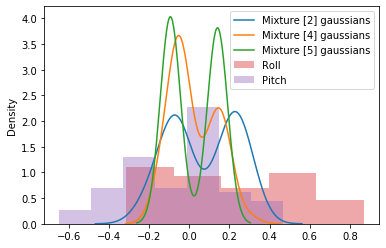

In [190]:
import sys
from sklearn.preprocessing import normalize
from scipy.stats import norm

n = len(dataset.y_all)
samples_dict = {2: [], 4:[], 5:[]}
for i in range(n):
    for model in [model_two, model_four, model_five]:
        pi_variable, sigma_variable, mu_variable = map(lambda x: x.data.numpy(), model(mean_bound))
        index = pi_variable.argmax()
        Z = np.random.choice([0,1]) 
        samples_dict[model.n_gaussians].append(np.random.normal(mu_variable[index+Z], sigma_variable[index], 1))
for ngaussian, samples in samples_dict.items():    
    sns.distplot(samples, hist=False, label=f"Mixture [{ngaussian}] gaussians")
sns.distplot(dataset.y_all[:, 0], kde=False, norm_hist=True, label="Roll")
sns.distplot(dataset.y_all[:, 1], kde=False, norm_hist=True, label="Pitch")
plt.legend()
plt.savefig(f"20kepochs_distr.png", dpi=150, bbox_inches='tight')
plt.show()

D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


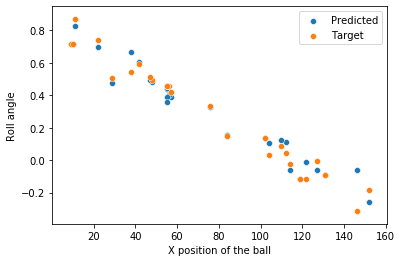

<Figure size 432x288 with 0 Axes>

In [94]:
samples = []
sort_by = np.argsort(dataset.y_val.data.numpy()[:, 0])
x_val = dataset.x_val[sort_by, :]
y_val = dataset.y_val[sort_by, :]
for n in range(len(x_val)):
    pi, sigma, mu = map(lambda x: x.data.numpy(), model(x_val[n]))
    index = pi.argmax()
    samples.append(np.random.normal(mu[index*2:(index+1)*2], sigma[index]))
samples = np.array(samples)
ax = sns.scatterplot(x_val[:, 0], samples[:, 0], label="Predicted")
sns.scatterplot( x_val[:, 0], y_val[:, 0], label="Target")
ax.set(ylabel="Roll angle", xlabel="X position of the ball")
plt.legend()
plt.show()
plt.savefig(f"{NGAUSSIANS}g_20kepochs_predictions_roll.png", dpi=150, bbox_inches='tight')

D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


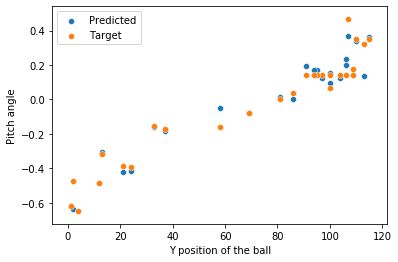

<Figure size 432x288 with 0 Axes>

In [99]:
ax = sns.scatterplot(x_val[:, 1], samples[:, 1], label="Predicted")
sns.scatterplot( x_val[:, 1], y_val[:, 1], label="Target")
ax.set(ylabel="Pitch angle", xlabel="Y position of the ball")
plt.legend()
plt.show()
plt.savefig(f"{NGAUSSIANS}g_20kepochs_predictions_pitch.png", dpi=150, bbox_inches='tight')

# Training the FFN

In [179]:
class FFN(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return self.fc2(x)
        

In [213]:
model_ffn = FFN(n_input=2, n_hidden=20, n_output=2)

In [214]:
ffn_train_losses = []
ffn_val_losses = []

In [215]:
def train_ffn(network, x_train, y_train, x_val, y_val, optimizer, criterion):
    for epoch in range(EPOCHS):
        prediction = network(x_train)
        train_loss = criterion(prediction, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        ffn_train_losses.append(train_loss.item())
        
        if len(x_val):
            prediction = network(x_val)
            val_loss = criterion(prediction, y_val)
            ffn_val_losses.append(val_loss.item())
        
        if epoch % 500 == 0:
            if len(x_val):
                print(epoch, train_loss.item(), val_loss.item())
            else:                
                print(epoch, train_loss.item())

In [183]:
optimizer = torch.optim.Adam(model_ffn.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() 

train_ffn(model_ffn, dataset.x_train, dataset.y_train, dataset.x_val, dataset.y_val, optimizer, criterion)

0 0.3482914865016937 0.20209014415740967
500 0.00511523662135005 0.01144341379404068
1000 0.004615024197846651 0.012053677812218666
1500 0.004553457722067833 0.01231544278562069
2000 0.0044312733225524426 0.01528790034353733
2500 0.004253795836120844 0.015059680677950382
3000 0.004077734891325235 0.015013577416539192
3500 0.003765449859201908 0.017069246619939804
4000 0.003821505466476083 0.017809687182307243
4500 0.0037543028593063354 0.017359083518385887
5000 0.003752233926206827 0.01686130091547966
5500 0.0036433329805731773 0.01764378510415554
6000 0.003918065223842859 0.017405381426215172
6500 0.003813232993707061 0.015692679211497307
7000 0.003723699599504471 0.016373898833990097
7500 0.0039247628301382065 0.012908668257296085
8000 0.0037233317270874977 0.013478399254381657
8500 0.004491924773901701 0.014538335613906384
9000 0.00373210315592587 0.013724646531045437
9500 0.0047440556809306145 0.01433162484318018
10000 0.0037705330178141594 0.014143615961074829
10500 0.003567546606

# Interpreting the results of the FFN

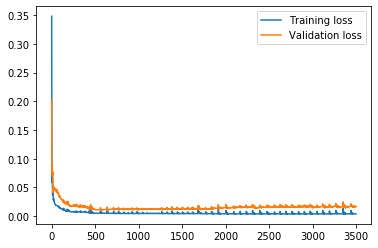

In [184]:
plt.plot(ffn_train_losses[:3500], label="Training loss")
plt.plot(ffn_val_losses[:3500], label="Validation loss")
plt.legend()
plt.savefig("ffn_plot.png")
plt.show()

In [216]:
optimizer = torch.optim.Adam(model_ffn.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() 

train_ffn(model_ffn, dataset.x_train, dataset.y_train, [], [], optimizer, criterion)

0 0.45653846859931946
500 0.003761282190680504
1000 0.0031117131002247334
1500 0.003151800250634551
2000 0.0031610801815986633
2500 0.0034011872485280037
3000 0.002956084907054901
3500 0.002946213586255908
4000 0.003545471467077732
4500 0.002887016162276268
5000 0.002939016791060567
5500 0.002892370568588376
6000 0.0028514242731034756
6500 0.004623791668564081
7000 0.002818482695147395
7500 0.0028749974444508553
8000 0.003641279647126794
8500 0.002761710435152054
9000 0.002759091090410948
9500 0.0027186318766325712
10000 0.002688279142603278
10500 0.0027955288533121347
11000 0.0031943318899720907
11500 0.003153851954266429
12000 0.00272001582197845
12500 0.003142063971608877
13000 0.0026631131768226624
13500 0.0034514444414526224
14000 0.0026026032865047455
14500 0.0026518888771533966
15000 0.0026415660977363586
15500 0.0025918299797922373
16000 0.002676890231668949
16500 0.002581018954515457
17000 0.0028205413836985826
17500 0.0025948600377887487
18000 0.0025863004848361015
18500 0.00

In [217]:
torch.save(model_ffn.state_dict(), f'ffn_model_nao_{int(EPOCHS/1000)}kepochs')

# Comparing the FFN and MDN

In [128]:
model.load_state_dict(torch.load(
    f'D:\Projects\Radboud Universiteit\Human-Robot Interaction\HRI_Tutorial2_students\part2\mdn_model_nao_20kepochs_{NGAUSSIANS}gaussians'))

<All keys matched successfully>

[MDN, 2] The outputted roll and pitch: (0.4489327073097229, 0.005710780620574951)
[MDN, 4] The outputted roll and pitch: (0.42946740984916687, 0.006362535059452057)
[MDN, 5] The outputted roll and pitch: (0.44971153140068054, 0.002745799720287323)
[FFN] The outputted roll and pitch: (0.4417767822742462, -0.005063772201538086)
The target roll and pitch: (tensor(0.4543), tensor(0.0014))


D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda3\lib\site-pac

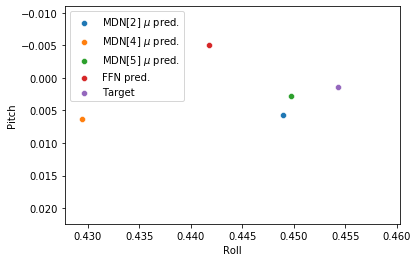

In [233]:
sample = 1
for ngaussians in [2, 4, 5]:
    model = MDN(n_input=2, n_hidden=20, n_output=2, n_gaussians=ngaussians)
    model.load_state_dict(torch.load(
    f'D:\Projects\Radboud Universiteit\Human-Robot Interaction\HRI_Tutorial2_students\part2\mdn_model_nao_20kepochs_{ngaussians}gaussians'))
    pi, sigma, mu = model(dataset.x_val)
    index = pi.argmax()
    roll_mu, pitch_mu = mu[index*2:(index+1)*2]
    print(f"[MDN, {ngaussians}] The outputted roll and pitch: {roll_mu.item(), pitch_mu.item()}")
    sns.scatterplot([roll_mu.item()], [pitch_mu.item()], label=fr"MDN[{ngaussians}] $\mu$ pred.")

roll, pitch = model_ffn(dataset.x_val)
print(f"[FFN] The outputted roll and pitch: {roll.item(), pitch.item()}")
sns.scatterplot([roll.item()], [pitch.item()], label="FFN pred.")
target_roll_mean, target_pitch_mean = dataset.y_val
print(f"The target roll and pitch: {target_roll_mean, target_pitch_mean}")
ax = sns.scatterplot([target_roll_mean], [target_pitch_mean], label="Target")
ax.set(xlabel="Roll", ylabel="Pitch")
plt.savefig("all_mod_predictions.png", dpi=150, bbox_inches='tight')
plt.show()